# Predicting Baseball Swings

---
embed-resources: true
---

## Introduction

Today, I will develop a model where it estimates the probability of a batter to swing at a pitch based on the characteristics of a pitch that was thrown to them. This model only works for the following dataset that was provided.

## Methods

In [2]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import brier_score_loss
import seaborn as sns
from pprint import pprint
from sklearn.calibration import calibration_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier

### Data

In [3]:
# load data
swing_train = pd.read_parquet(
    "https://cs307.org/lab/data/swing-train.parquet",
)
swing_test = pd.read_parquet(
    "https://cs307.org/lab/data/swing-test.parquet",
)
swing_train

,pitch_name,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_axis,plate_x,plate_z,...,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,stand,sz_top,sz_bot,swing
0,Cutter,6.6,-2.76,53.86,5.81,92.6,2376.0,195.0,-0.09,2.79,...,3,1,0,0,0,1,L,3.15,1.52,1
1,Changeup,6.8,-2.87,53.74,5.66,86.3,1511.0,226.0,-1.47,1.84,...,2,1,0,0,0,1,L,3.13,1.56,0
2,Changeup,6.7,-2.83,53.82,5.68,87.9,1570.0,224.0,-1.52,2.38,...,1,1,0,0,0,1,L,3.12,1.51,0
3,Knuckle Curve,6.7,-2.70,53.78,5.78,82.4,2398.0,32.0,0.20,1.04,...,1,0,0,0,0,1,L,3.15,1.52,1
4,Cutter,6.7,-2.64,53.83,5.81,91.0,2427.0,189.0,0.89,1.65,...,0,0,0,0,0,1,L,3.12,1.51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2659,4-Seam Fastball,6.8,-2.64,53.75,5.99,93.4,2411.0,206.0,0.59,2.91,...,0,0,0,0,0,1,L,3.50,1.81,0
2660,Slider,6.3,-2.91,54.19,5.86,87.3,2541.0,113.0,1.38,1.73,...,1,2,0,0,0,0,R,3.19,1.48,1
2661,Knuckle Curve,6.4,-2.91,54.13,5.87,84.7,2539.0,35.0,0.81,0.11,...,1,1,0,0,0,0,R,3.19,1.48,1
2662,4-Seam Fastball,6.4,-2.67,54.13,6.04,94.3,2531.0,201.0,1.05,1.79,...,0,1,0,0,0,0,R,3.03,1.48,0


In the train data above, we have 2663 rows where each row represents a pitch and its 22 characteristics. The features of this data include:

### Response 

**`swing`**

- [int64] Whether or not the batter swung (1) or took (0).


### Fully Pitcher Controlled Features

**`pitch_name`**

- [object] The name of the pitch type to be thrown.

### Mostly Pitcher Controlled

**`release_extension`**

- [float64] Release extension of pitch in feet as tracked by Statcast.

**`release_pos_x`**

- [float64] Horizontal Release Position of the ball measured in feet from the catcher’s perspective.

**`release_pos_y`**

- [float64] Release position of pitch measured in feet from the catcher’s perspective.

**`release_pos_z`**

- [float64] Vertical Release Position of the ball measured in feet from the catcher’s perspective.

### Somewhat Pitcher Controlled

**`release_speed`**

- [float64] Velocity of the pitch thrown.

**`release_spin_rate`**

- [float64] Spin rate of pitch tracked by Statcast.

**`spin_axis`**

- [float64] The spin axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball.

**`plate_z`**

- [float64] Vertical position of the ball when it crosses home plate from the catcher’s perspective.

### Downstream Pitcher Controlled

**`pfx_x`**

- [float64] Horizontal movement in feet from the catcher’s perspective.

**`pfx_z`**

- [float64] Vertical movement in feet from the catcher’s perspective.

### Situational Information

**`balls`**

- [int64] Pre-pitch number of balls in count.

**`strikes`**

- [int64] Pre-pitch number of strikes in count.

**`on_3b`**

- [int64] Pre-pitch MLB Player Id of Runner on 3B.

**`on_2b`**

- [int64] Pre-pitch MLB Player Id of Runner on 2B.

**`on_1b`**

- [int64] Pre-pitch MLB Player Id of Runner on 1B.

**`outs_when_up`**

- [int64] Pre-pitch number of outs.

### Fixed Batter Information

**`stand`**

- [object] Side of the plate batter is standing.

**`sz_top`**

- [float64] Top of the batter’s strike zone set by the operator when the ball is halfway to the plate.

**`sz_bot`**

- [float64] Bottom of the batter’s strike zone set by the operator when the ball is halfway to the plate.


In [4]:
swing = swing_train[swing_train['swing'] == 1]
swing

,pitch_name,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_axis,plate_x,plate_z,...,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,stand,sz_top,sz_bot,swing
0,Cutter,6.6,-2.76,53.86,5.81,92.6,2376.0,195.0,-0.09,2.79,...,3,1,0,0,0,1,L,3.15,1.52,1
3,Knuckle Curve,6.7,-2.70,53.78,5.78,82.4,2398.0,32.0,0.20,1.04,...,1,0,0,0,0,1,L,3.15,1.52,1
6,Slider,6.8,-2.73,53.74,5.81,88.9,2273.0,166.0,-0.09,1.96,...,1,1,0,0,0,0,R,3.32,1.64,1
7,Knuckle Curve,6.6,-2.58,53.91,5.87,82.1,2411.0,32.0,0.24,2.07,...,1,0,0,0,0,0,R,3.32,1.64,1
9,4-Seam Fastball,6.9,-2.56,53.65,5.91,93.4,2341.0,207.0,0.48,2.29,...,2,0,0,0,0,0,L,3.46,1.61,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,Knuckle Curve,6.4,-2.90,54.12,5.99,83.8,2538.0,37.0,0.20,2.45,...,0,0,0,0,0,2,R,3.36,1.58,1
2657,Slider,6.5,-2.96,53.96,5.83,88.0,2508.0,157.0,0.84,1.84,...,0,2,0,0,0,1,L,3.64,1.81,1
2658,4-Seam Fastball,6.2,-2.84,54.26,6.06,93.5,2316.0,203.0,0.14,3.21,...,0,1,0,0,0,1,L,3.64,1.81,1
2660,Slider,6.3,-2.91,54.19,5.86,87.3,2541.0,113.0,1.38,1.73,...,1,2,0,0,0,0,R,3.19,1.48,1


In [5]:
swing_total = 1271
total = 2663
swing_porp = swing_total / total
swing_porp

0.47728126173488544

Out of all 2663 pitches that were thrown, only 1271 of those pitches were actually swung at which gives us a swing rate of about 47.73%.

In [6]:
# summary statistics
count = swing_train['pitch_name'].value_counts()
swing_count = swing['pitch_name'].value_counts()
swing_count / count

pitch_name
4-Seam Fastball    0.470904
Knuckle Curve      0.462875
Changeup           0.536313
Cutter             0.451477
Slider             0.496124
Name: count, dtype: float64

This shows us the proportion of each pitch type that was swung at

/var/folders/tb/gxmnn8011191kwx1sz61vls40000gq/T/ipykernel_30352/4007947967.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=swing_count.index, y=swing_count.values, palette="viridis")


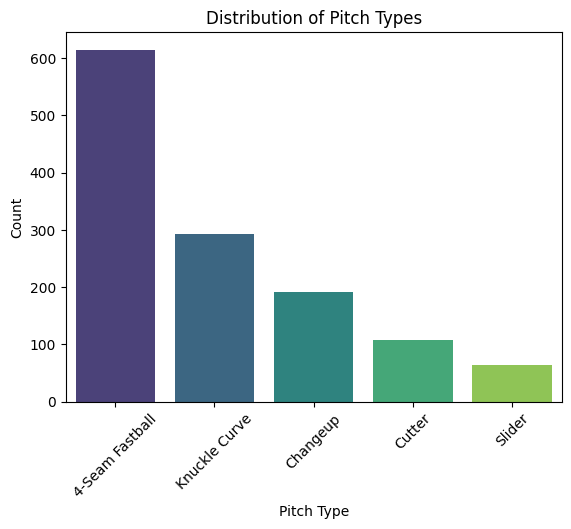

In [7]:
# exploratory visualization
sns.barplot(x=swing_count.index, y=swing_count.values, palette="viridis")
plt.title("Distribution of Pitch Types")
plt.xlabel("Pitch Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

From the barplot above, we are able to see the distribution of pitch types and how many there are. This can be important later on to discuss the preformance of our model.

### Models

In [8]:
# process data for ML
# create X and y for train data
X_train = swing_train.drop(columns=["swing"])
y_train = swing_train["swing"]

# create X and y for test data
X_test = swing_test.drop(columns=["swing"])
y_test = swing_test["swing"]
numeric = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical = X_train.select_dtypes(include=['object']).columns

I categorize the data into numerical and categorical data to put into pipelines so that our model will be able to use the pipelines for proper analysis

In [9]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder(handle_unknown='infrequent_if_exist')
)
preprocessor = make_column_transformer(
    (numeric_transformer, numeric),
    (categorical_transformer, categorical),
    remainder='drop'
)
pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', HistGradientBoostingClassifier(random_state=42))
])

In [10]:
# function to calculate the calibration error
def calibration_error(y_true, y_prob, type="expected", n_bins=5):
    """
    Compute calibration error of a binary classifier.

    The calibration error measures the aggregated difference between
    the average predicted probabilities assigned to the positive class,
    and the frequencies of the positive class in the actual outcome.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True targets of a binary classification task.

    y_prob : array-like of (n_samples,)
        Estimated probabilities for the positive class.

    type : {'expected', 'max'}, default='expected'
        The expected-type is the Expected Calibration Error (ECE), and the
        max-type corresponds to Maximum Calibration Error (MCE).

    n_bins : int, default=10
       The number of bins used when computing the error.

    Returns
    -------
    score : float
        The calibration error.
    """

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_idx = np.searchsorted(bins[1:-1], y_prob)

    bin_sums = np.bincount(bin_idx, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(bin_idx, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(bin_idx, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    if type == "max":
        calibration_error = np.max(np.abs(prob_pred - prob_true))
    elif type == "expected":
        bin_error = np.abs(prob_pred - prob_true) * bin_total[nonzero]
        calibration_error = np.sum(bin_error) / len(y_true)

    return calibration_error

The function above is used to get our calibration errors

In [11]:
# train models
calibrated = CalibratedClassifierCV(estimator=pipeline, method='sigmoid', cv=5)

param_grid = {
    'estimator__clf__learning_rate': [0.01, 0.05, 0.1],
    'estimator__clf__max_depth': [3, 5, 7],
    'method': ['sigmoid', 'isotonic']
}

grid = GridSearchCV(
    estimator=calibrated,
    param_grid=param_grid,
    scoring='neg_brier_score',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

We first get the best possible parameters for our model before testing it on the test data

## Results

In [12]:
# Predict and score
probs = best_model.predict_proba(X_test)[:, 1]
brier = brier_score_loss(y_test, probs)
print("Best params:", grid.best_params_)
print("Best Brier Score:", brier)
test_ece_calibrated = calibration_error(
    y_test,
    probs,
    type="expected",
)
test_mce_calibrated = calibration_error(
    y_test,
    probs,
    type="max",
)
print(f"Test ECE: {test_ece_calibrated}")
print(f"Test MCE: {test_mce_calibrated}")

Best params: {'estimator__clf__learning_rate': 0.05, 'estimator__clf__max_depth': 5, 'method': 'isotonic'}
Best Brier Score: 0.18073705398078935
Test ECE: 0.03235753448738987
Test MCE: 0.07215535173769508


After getting our best model, we are able to achieve a Brier Score of 0.1807, an ECE score of 0.0323, and a MCE score of 0.0722

In [13]:
# serialize model
dump(best_model, 'swing.joblib')

['swing.joblib']

## Discussion

After making our final model, it was able to achieve a Brier Score of 0.1807, an ECE score of 0.0323, and a MCE score of 0.0722. So what does this all mean? A brier score is basically the mean squared error between the predicted and actual value so the lower the score the better. Expected Calibration Error (ECE) shows us how well the model's predictions matches the actual values which also means that the low ECE is good. Lastly, Maximum Calibration Error (MCE) shows us the biggest difference from a model's predicted value and its actual value and we also want a low score for this.

First our Brier Score of 0.1807 means that our model's predictions were about 18% off from the actual value which is pretty close. Our ECE score shows the model's confidence is off by 3.2% from the actual value which is also pretty good. Lastly, our MCE shows that the models worst prediction was off by 7.2% from the actual value which isn't that far off. 

The calibration plot below shows us how well our model did. The orange line represents a perfect prediction model would look like and the blue line is our model. We want the blue line to be as close as possible to the orange line. Our model has some points that are very close to the orange line which is good but there are some points a bit far from the orange line but nothing too far.

These are impressive scores and our model has done well, but when thinking about using this model in a real game, we should proceed with caution. We should not rely on this model alone because it's not perfect. If we want to use this for a real game, we should aim for lower scores and a plot that shows the blue line being even closer to the orange line. If this model were to predict incorrectly during a tight game, it could cost a team a victory. 

We could improve this model even more by collecting more data or adding equal parts of data. As seen above from the barplot, our data has a lot of data for 4-seam fastballs but not so much for the other pitch types. Having an equal amount of each pitch type allows the model to see patterns clearer between each pitch type instead of just one. So since we have a lot of data on 4-seam fastballs, our model will accurately predict that pitch type more than the others since there isn't that much data for the others.

Overall, we should not use this model for a real game but it can be helpful to use for recreational use or for practices.

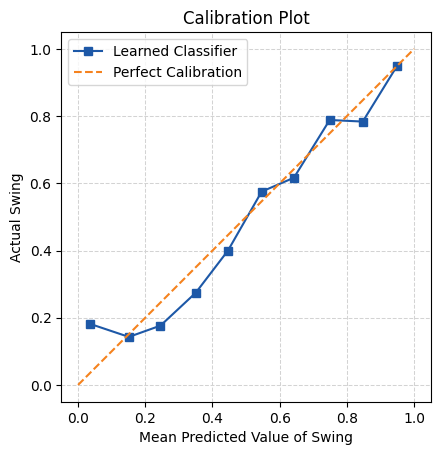

In [14]:
# function to plot a calibration_plot
def plot_calibration_plot(y_true, y_prob):

    # generate "data" for calibration plot
    prob_true, prob_pred = calibration_curve(
        y_true,
        y_prob,
        n_bins=10,
        pos_label=1,
    )

    # create a figure and axis object with a specific size
    fig, ax = plt.subplots()

    # plot the calibration curve
    ax.plot(
        prob_pred,
        prob_true,
        "s-",
        label="Learned Classifier",
        color="#1D58A7",
    )

    # plot the diagonal "perfect" line
    ax.plot(
        [0, 1],
        [0, 1],
        "--",
        label="Perfect Calibration",
        color="#F5821E",
    )

    # set the plot title and axis labels
    ax.set_title("Calibration Plot")
    ax.set_xlabel("Mean Predicted Value of Swing")
    ax.set_ylabel("Actual Swing")

    # add a grid
    ax.grid(
        True,
        color="lightgrey",
        linewidth=0.75,
        linestyle="--",
    )

    # fix aspect ratio
    ax.set_aspect(
        "equal",
        adjustable="box",
    )

    # show the legend
    ax.legend()

    # show the plot
    plt.show()
plot_calibration_plot(y_test, probs)